## 使用VAE 生成圖片

### 引用套件

In [58]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from   scipy.stats import norm
import matplotlib.image as matimg
import glob

from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives

### 設定網路參數

In [81]:
num_training_examples = 100
num_testing_examples  = 30

batch_size   = 5
original_dim = 64 * 64 * 3 #this is same as image_vector_size
latent_dim   = 4
intermediate_dim = 256
epsilon_std  = 1.0

In [82]:
def load_image(path):
    img = matimg.imread(path)
    return img

#following code loads data from local repo
#directory should have two subfolders, with name train and test
def load_local_data(path):
    paths = glob.glob(os.path.join(path + "/train", "*.jpg"))
    X_train = np.array( [ load_image(p) for p in paths ] )

    paths = glob.glob(os.path.join(path + "/test", "*.jpg"))
    X_test = np.array( [ load_image(p) for p in paths ] )
   
    return X_train, X_test

### 建立 Encoder

In [83]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean    = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

### 取樣函數

In [84]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### 建立解碼器

In [85]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h    = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded    = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

### 計算 VAE 損失


In [86]:
# modified calculation of loss
def vae_loss(x, x_decoded_mean):
    # xent_loss is reconstruction error
    # use binary_crossentropy because this is not multi-label classification or regression but unsupervised problem
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

### 建立 VAE 模型

In [87]:
# vae model
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# if want to train with data from local repo
path="../idol_face_vae"
(x_train, x_test) = load_local_data(path)

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32')  / 255.

In [88]:
x_train.shape

(100, 64, 64, 3)

In [89]:
x_test.shape

(30, 64, 64, 3)

In [90]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [91]:
x_train.shape

(100, 12288)

In [92]:
x_test.shape

(30, 12288)

In [93]:
#to train the model
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=50,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

D:\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 100 samples, validate on 30 samples
Epoch 1/50
100/100 [==============================] - 3s 31ms/step - loss: 10134.3834 - val_loss: 7725.2170
Epoch 2/50
100/100 [==============================] - 3s 26ms/step - loss: 7883.9218 - val_loss: 7619.9267
Epoch 3/50
100/100 [==============================] - 2s 24ms/step - loss: 11590.4038 - val_loss: 7832.1498
Epoch 4/50
100/100 [==============================] - 2s 24ms/step - loss: 7836.6870 - val_loss: 7639.4769
Epoch 5/50
100/100 [==============================] - 2s 24ms/step - loss: 7811.4393 - val_loss: 7673.0011
Epoch 6/50
100/100 [==============================] - 2s 24ms/step - loss: 7734.6896 - val_loss: 7645.7768
Epoch 7/50
100/100 [==============================] - 2s 25ms/step - loss: 7908.5535 - val_loss: 7944.2258
Epoch 8/50
100/100 [==============================] - 2s 24ms/step - loss: 7821.3207 - val_loss: 7874.7607
Epoch 9/50
100/100 [==============================] - 3s 25ms/step - loss: 7861.4211 - val_loss: 

### 產生生成器

In [94]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded      = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### 圖片生成

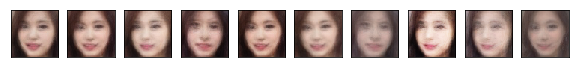

In [97]:
img_size = 64

# following values can generate some good skyline images
samples         = x_test[15:25]

# code to create a result.png with generated images
plt.figure(figsize=(10, 2))

for i, yi in enumerate(x_test_encoded[15:25]):
    z_sample = np.array([[yi[0], yi[1], yi[2], yi[3]]])
    x_decoded = generator.predict(z_sample)
    x_decoded.shape is (1, img_size * img_size * 3)
    face = x_decoded[0].reshape(img_size, img_size, 3)
    ax = plt.subplot(2, 10, i + 10 + 1)
    plt.imshow(face)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#     ax1 = plt.subplot(2, 10, i + 1)
#     plt.imshow(samples[i].reshape(img_size, img_size, 3))
#     ax1.get_xaxis().set_visible(False)
#     ax1.get_yaxis().set_visible(False)

plt.savefig('result.png')
plt.show()